<a href="https://colab.research.google.com/github/skywalker0803r/pytorch_Exercise/blob/master/Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gym, os
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm import tqdm_notebook as tqdm

# hyperparams

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v0").unwrapped

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
lr = 0.0001

# actor

In [0]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, self.action_size)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        return output

# critic

In [0]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

# get Gt

In [0]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

# initialize all

In [0]:
actor = Actor(state_size, action_size).to(device)
critic = Critic(state_size, action_size).to(device)
optimizerA = optim.Adam(actor.parameters())
optimizerC = optim.Adam(critic.parameters())

# train loop

In [7]:
for iter in tqdm(range(150)):
    
    state = env.reset()
    log_probs = []
    values = []
    rewards = []
    masks = []
    entropy = 0
    env.reset()
    
    for i in count():
        
        state = torch.FloatTensor(state).to(device)
        output, value = actor(state), critic(state)
        dist = Categorical(F.softmax(output, dim=-1))

        action = dist.sample()
        next_state, reward, done, _ = env.step(action.cpu().numpy())

        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy += dist.entropy().mean()

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
        masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

        state = next_state

        if done:
            print('Iteration: {}, Score: {}'.format(iter, i))
            break


    next_state = torch.FloatTensor(next_state).to(device)
    next_value = critic(next_state)
    returns = compute_returns(next_value, rewards, masks)

    log_probs = torch.cat(log_probs)
    returns = torch.cat(returns).detach()
    values = torch.cat(values)

    advantage = returns - values

    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    optimizerA.zero_grad()
    optimizerC.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    optimizerA.step()
    optimizerC.step()

env.close()

Iteration: 0, Score: 14
Iteration: 1, Score: 13
Iteration: 2, Score: 23
Iteration: 3, Score: 11
Iteration: 4, Score: 11
Iteration: 5, Score: 19
Iteration: 6, Score: 14
Iteration: 7, Score: 20
Iteration: 8, Score: 37
Iteration: 9, Score: 24
Iteration: 10, Score: 23
Iteration: 11, Score: 16
Iteration: 12, Score: 22
Iteration: 13, Score: 16
Iteration: 14, Score: 12
Iteration: 15, Score: 55
Iteration: 16, Score: 25
Iteration: 17, Score: 19
Iteration: 18, Score: 25
Iteration: 19, Score: 18
Iteration: 20, Score: 16
Iteration: 21, Score: 19
Iteration: 22, Score: 44
Iteration: 23, Score: 113
Iteration: 24, Score: 17
Iteration: 25, Score: 48
Iteration: 26, Score: 30
Iteration: 27, Score: 23
Iteration: 28, Score: 14
Iteration: 29, Score: 33
Iteration: 30, Score: 24
Iteration: 31, Score: 25
Iteration: 32, Score: 45
Iteration: 33, Score: 31
Iteration: 34, Score: 30
Iteration: 35, Score: 47
Iteration: 36, Score: 10
Iteration: 37, Score: 51
Iteration: 38, Score: 89
Iteration: 39, Score: 82
Iteration

# test

In [8]:
for iter in tqdm(range(10)):
    state = env.reset()
    R = 0
    while True:
        state = torch.FloatTensor(state).to(device)
        output = actor(state)
        dist = F.softmax(output, dim=-1)
        action = torch.argmax(dist,dim=-1)
        next_state, reward, done, _ = env.step(action.cpu().numpy())
        R += reward
        if done:
            break
        state = next_state
    print('Iteration: {}, Score: {}'.format(iter,R))

Iteration: 0, Score: 493.0
Iteration: 1, Score: 416.0
Iteration: 2, Score: 521.0
Iteration: 3, Score: 542.0
Iteration: 4, Score: 442.0
Iteration: 5, Score: 1054.0
Iteration: 6, Score: 602.0
Iteration: 7, Score: 456.0
Iteration: 8, Score: 807.0
Iteration: 9, Score: 487.0



# torchviz

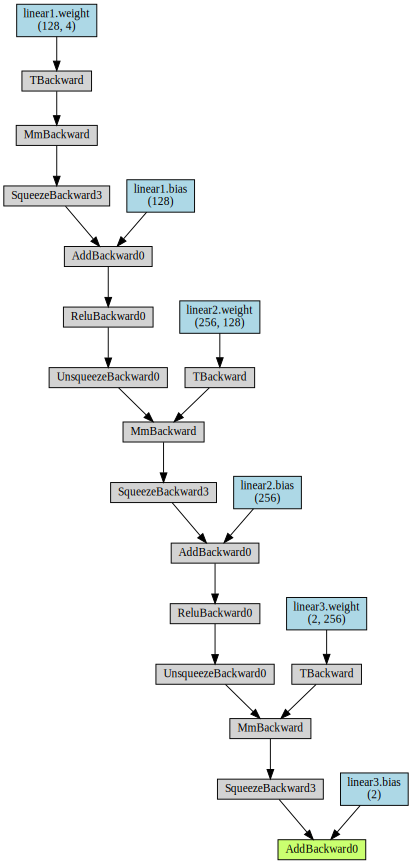

In [9]:
import torchviz

state = env.reset()
state = torch.FloatTensor(state).to(device)
torchviz.make_dot(actor(state),params=dict(actor.named_parameters()))

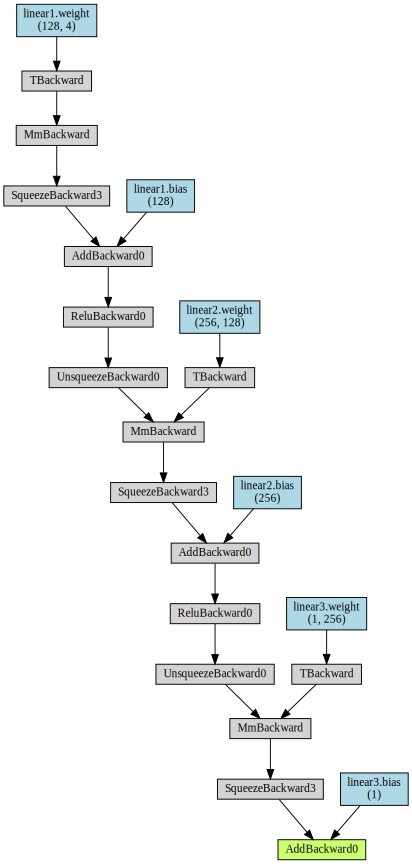

In [10]:
torchviz.make_dot(critic(state),params=dict(critic.named_parameters()))